# Channel Quality Index (CQI) Generation

In this example, we will simulate a fading channel, and channel quality index (CQI) generation based on the effective exponential SIR metric (EESM) approach.

In [ ]:
import py_itpp as pyp
from matplotlib import pyplot as plt

## Create the CQI table 

LTE TS36.213 Table 7.2.3-1

In [ ]:
cqi_table = {}
cqi_table['cqi_index'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
cqi_table['modulation_index'] = [0, 2, 2, 2, 2, 2, 2, 4, 4, 4, 6, 6, 6, 6, 6, 6]
cqi_table['code_rates'] = [0, 78, 120, 193, 308, 449, 602, 378, 490, 616, 466, 567, 666, 772, 873, 948]

nrof_cqi = len(cqi_table['code_rates'])

# Print the CQI table
print('CQI Index\t Modulation Index\t Code Rate x 1024')
for i in range(16):
    print('\t%d\t \t%d\t \t%d'%(cqi_table['cqi_index'][i], 
                                     cqi_table['modulation_index'][i], 
                                     cqi_table['code_rates'][i]))

## Define AWGN BLER curves

In [ ]:
AWGN_EbN0_dB = pyp.vec('0:0.1:16')
awgn_bler_curve = pyp.mat(AWGN_EbN0_dB.length(), nrof_cqi)

awgn_bler_curve.clear()
temp_curve = pyp.vec(AWGN_EbN0_dB.length())
for i in range(nrof_cqi):
    temp_curve.clear()    
    temp_curve.set_subvector(0, pyp.ones(i * 10))  # Set BLER 1 for low SNRs
    temp_curve.set_subvector(i * 10 , pyp.vec('1:-0.1:0'))  # Linear BLER decrease to 0
    awgn_bler_curve.set_col(i, temp_curve)

# Plot AWGN BLER curves
plt.figure()
for i in range(nrof_cqi):
    plt.semilogy(AWGN_EbN0_dB.to_numpy_ndarray(), awgn_bler_curve.get_col(i).to_numpy_ndarray())

plt.ylim([1e-2, 1])
plt.xlabel('EbN0_dB')
plt.ylabel('BLER')

## Function to estimate CQI index
Now we can define a function that returns the largest CQI index for which the AWGN BLER is less than or 
equal to given BLER target for the given sinr value (in dB).

In [ ]:
AWGN_EbN0_min = pyp.math.min(AWGN_EbN0_dB)
AWGN_EbN0_interval = (pyp.math.max(AWGN_EbN0_dB) - AWGN_EbN0_min) / AWGN_EbN0_dB.length()
def determine_cqi_index(effective_sinrs, bler_target=0.1):
    for i in range(nrof_cqi):
        sinr_in = effective_sinrs[nrof_cqi - i - 1]
        # Find index of the closest SINR less than sinr_in [dB]
        awgn_sinr_index = int((sinr_in - AWGN_EbN0_min) / AWGN_EbN0_interval)
        equivalent_awgn_bler = awgn_bler_curve.get(awgn_sinr_index, nrof_cqi - i - 1)
        if (sinr_in > AWGN_EbN0_min) and (equivalent_awgn_bler <= bler_target):
            return (nrof_cqi - i - 1)
        elif (i == nrof_cqi - 1):
            return 0

# Radio link parameters
We now define the radio link parameters related to the transmission bandwidth, transmission duration, and the speed of terminal. We simulate an LTE-link link chain, where the LTE carrier spans 6 resource blocks (i.e., 72 subcarriers). Further, the transmission duration is 1 millisecond (i.e., a single LTE subframe).

In [46]:
# Sampling frequency and interval
fft_size = 128
subcarrier_spacing = 15000 # Hz
sampling_frequency = subcarrier_spacing * fft_size 
sampling_interval = 1.0 / sampling_frequency

# Transmission bandwidth and duration
nrof_subcarriers = 72
transmission_duration = 71.4e-6 # in seconds

# Maximum Doppler frequency assuming a 2Ghz carrier
relative_speed = 3.3 # in m/s
doppler_frequency = (2e9 / 3e8) * relative_speed

# Average signal to noise ratio over transmission bandwidth
snr_dB = 10
noise_variance = pyp.math.inv_dB(-snr_dB)  # Normalizing the received power to 1 (=0 dB)

## Set up the channel

We set up a fading channel. py-itpp supports stochastic tapped delay line (TDL) channel models. In case of TDL channels, the channel impulse response is modeled as several time-delayed 'taps', where each tap is a random variable with a defined . The channel response is therefore,
$$h = \sum_{p=1}^{P}\delta(t-\tau_p)h(\tau_p)$$,
where $P$ is the number of taps and $h$ is the amplitude,modeled as a Rayleigh fading distribution.
Currently, there is no support for spatial / geometric channel models. The following TDL channel profiles are supported by py-itpp:

ITU_Vehicular_A,
ITU_Vehicular_B, 
ITU_Pedestrian_A,
ITU_Pedestrian_B,
COST207_RA,
COST207_RA6,
COST207_TU,
COST207_TU6alt,
COST207_TU12,
COST207_TU12alt,
COST207_HT,
COST207_HT6alt,
COST207_HT12,
COST207_HT12alt,
COST259_TUx,
COST259_RAx,
COST259_RAx.

In [47]:
# Specify the channel model
channel_spec = pyp.comm.Channel_Specification(pyp.comm.CHANNEL_PROFILE.ITU_Vehicular_A)

# Create the channel model
channel = pyp.comm.TDL_Channel(channel_spec, sampling_interval)

# Set the normalized channel doppler for a 2 GHz carrier frequency
norm_doppler = doppler_frequency * sampling_interval
print('Normalized Doppler: %f'%(norm_doppler))
channel.set_norm_doppler(norm_doppler)

Normalized Doppler: 0.000011


## Generate channel samples in frequency domain
Here we generate some samples of the channel impulse response (CIR). Then we convert the CIR samples to frequency domain by taking the fourier transform of the CIRs for a given number of subcarriers.

In [48]:
# Define number of channel samples to generate and the offset between each sample.
nrof_channel_samples = 100

# Placeholder to store channel impulse responses
nrof_taps = channel.taps()
channel_impulse_response = pyp.cmat(nrof_taps, nrof_channel_samples) 
channel_frequency_response = pyp.cmat(nrof_subcarriers, nrof_channel_samples)
#channel_impulse_responses.set_size(nrof_channel_samples, nrof_taps, False)

# Generate channel samples. Each channel sample is shifted by the transmission duration
sample_channel_coeff = pyp.cmat()
for sample_index in range(nrof_channel_samples):
    channel.set_time_offset(sample_index * int(1e-3 / sampling_interval))
    
    channel.generate(1, sample_channel_coeff) # Generate a single channel sample with current time offset

    channel_impulse_response.set_col(sample_index, sample_channel_coeff.get_row(0))
    
    # Obtain the channel frequency response by taking FFT of channel impulse response.
    # The FFT size is 2^n for computation speed, from which we extract nrof_subcarrier values.
    channel_impuse_fft = pyp.signal.fft(channel_impulse_response.get_col(sample_index), fft_size)
    channel_frequency_response.set_col(sample_index, channel_impuse_fft.left(nrof_subcarriers))

# Visualize the channel response

Before we calculate the CQI, we can take a short aside and visualize the channel response, in terms of the average SINR in the frequency domain for each channel sample. This will help us appreciate the variation in CQI over time. Note that averaging the SINR is a rough measure of the channel quality, so although the average SINR curve should look similar to the CQI curve over time, the two curves will most likely not be identical. In fact, the similarity between average SINR and CQI curves depends on the frequency selectivity of the channel - a frequency flat channel will have similar curves for both, while the curves for a frequency selective channel can look dissimilar.

Text(0.5,0,'Channel Magnitude')

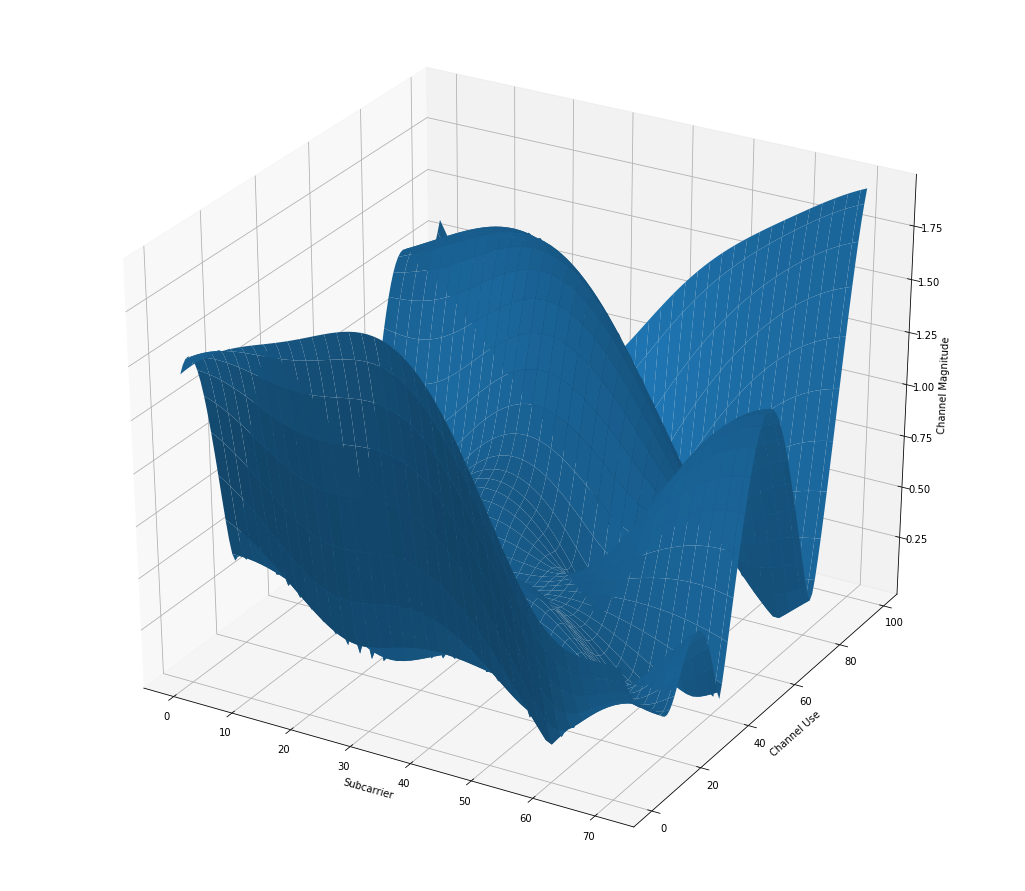

In [49]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

channel_magnitude = pyp.math.abs(channel_frequency_response)

plt.figure(figsize=(18, 16))
Z = channel_magnitude.get_cols(0, 99).to_numpy_ndarray()
x = np.arange(0, nrof_subcarriers)
y = np.arange(0, 100)
X, Y = np.meshgrid(x, y)
plt.gca(projection='3d').plot_surface(X, Y, np.transpose(Z))

plt.gca().set_xlabel('Subcarrier')
plt.gca().set_ylabel('Channel Use')
plt.gca().set_zlabel('Channel Magnitude')

## Calculate the EESM value for each channel sample

The effective exponential SIR metric (EESM) is defined as 
$$eesm_k = -\beta_k\log\left(\frac{1}{M}\sum_{m=1}^{M}e^{-\frac{\gamma_m}{\beta_k}}\right)$$
, where $M$ is the number of subcarriers, and $\beta_k$ is estimated through simulations.

In [ ]:
eesm_dB = pyp.mat()
eesm_dB.set_size(nrof_channel_samples, nrof_cqi, False)

eesm_beta = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

for i in range(nrof_channel_samples):
    channel_response = pyp.math.abs(channel_frequency_response.get_col(i))
    snr_per_subcarrier = pyp.math.pow(channel_response, 2) * (1.0 / noise_variance)
   
    for j in range(nrof_cqi):
        v = pyp.math.exp(-1.0 * snr_per_subcarrier / eesm_beta[j])
        eesm_value = -1.0 * eesm_beta[j] * pyp.math.log(pyp.stat.mean(v))  
        eesm_dB.set(i, j, pyp.math.dB(eesm_value))
    
plt.figure()
plt.plot(eesm_dB.get_col(0).to_numpy_ndarray())

## Estimate the CQI for each channel sample

In [ ]:
cqi = pyp.ivec(nrof_channel_samples)
for i in range(nrof_channel_samples):
    cqi.set(i, determine_cqi_index(eesm_dB.get_row(i)))
    
plt.figure()
plt.plot(cqi.to_numpy_ndarray())